# =============================================================================
# # Telco Customer Churn Prediction
# This notebook walks through a complete machine learning project to predict
# customer churn for a telecommunications company.
# =============================================================================

In [1]:
# --- Step 0: Environment Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay

In [2]:
# --- Step 1: Data Loading and Initial Inspection ---
print("\n--- Step 1: Loading Data ---")
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)
print("Data loaded successfully.")

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nGeneral dataset information:")
df.info()


--- Step 1: Loading Data ---
Data loaded successfully.

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  .


--- Step 2: Data Cleaning and EDA ---
Cleaned 'TotalCharges' column and imputed missing values.
Mapped 'Churn' column to 0s and 1s.


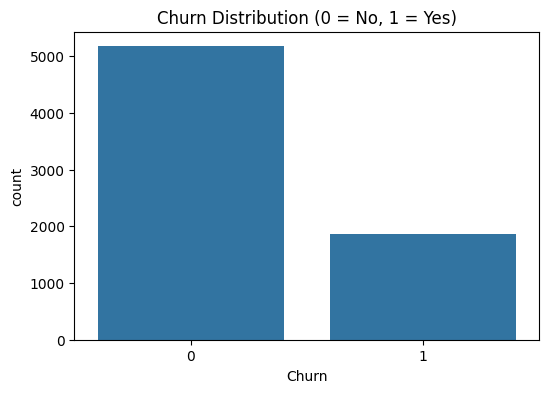

Retention Rate: 73.46%
Churn Rate: 26.54%


In [3]:
# --- Step 2: Data Cleaning and Exploratory Data Analysis (EDA) ---
print("\n--- Step 2: Data Cleaning and EDA ---")

# Correct the 'TotalCharges' column type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Impute missing values in 'TotalCharges' with the median
# This approach avoids the FutureWarning and is safer.
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print("Cleaned 'TotalCharges' column and imputed missing values.")

# Map the target variable 'Churn' to numerical format (0 and 1)
# This check makes the cell idempotent (safe to run multiple times).
if df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    print("Mapped 'Churn' column to 0s and 1s.")
else:
    print("'Churn' column is already in numerical format.")

# --- EDA Part 1: Analyzing the Target Variable ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution (0 = No, 1 = Yes)')
plt.show()

churn_rate = df['Churn'].value_counts(normalize=True) * 100
print(f"Retention Rate: {churn_rate[0]:.2f}%")
print(f"Churn Rate: {churn_rate[1]:.2f}%")



Analyzing categorical features vs. churn...


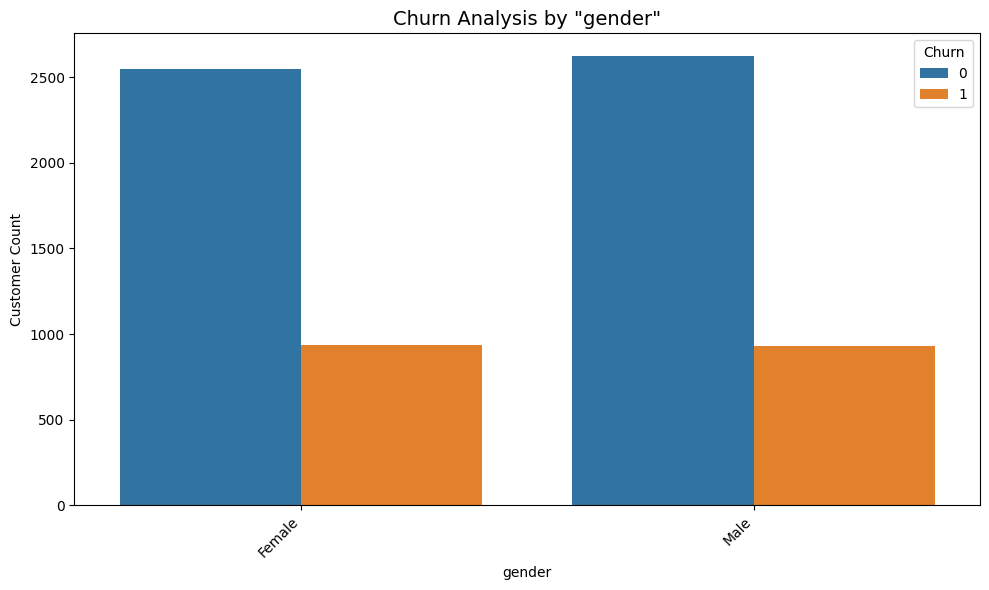

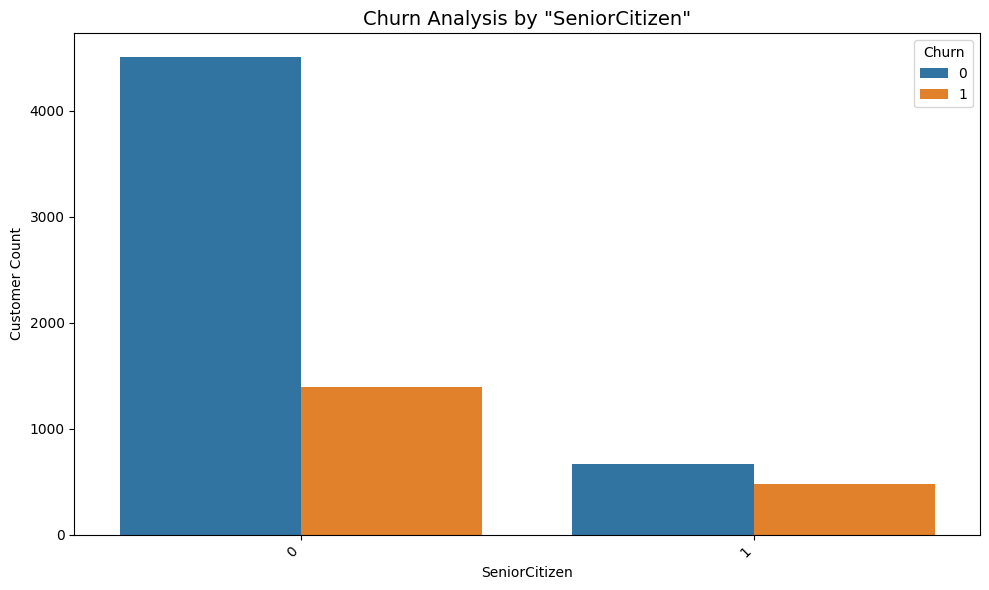

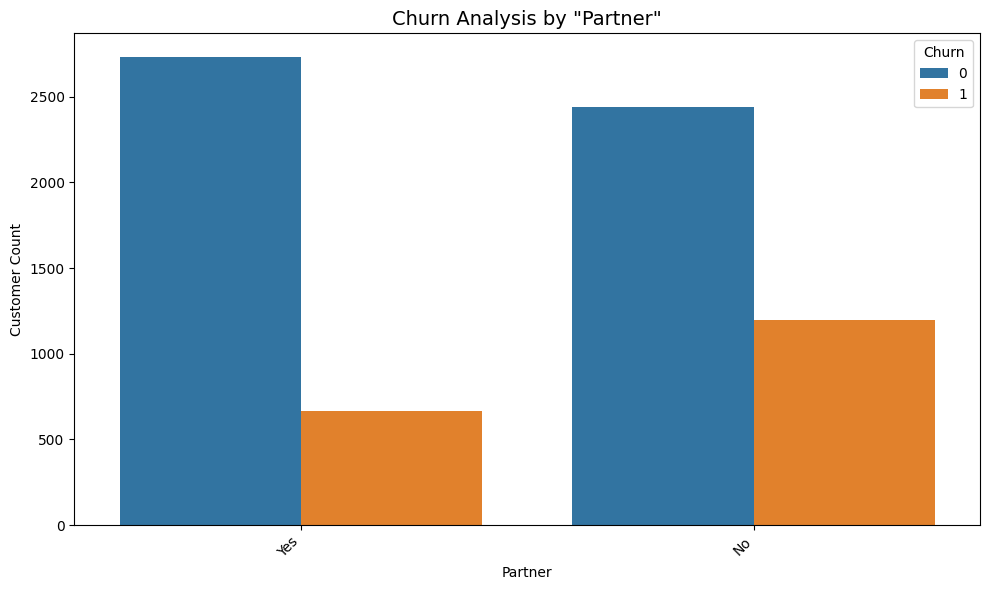

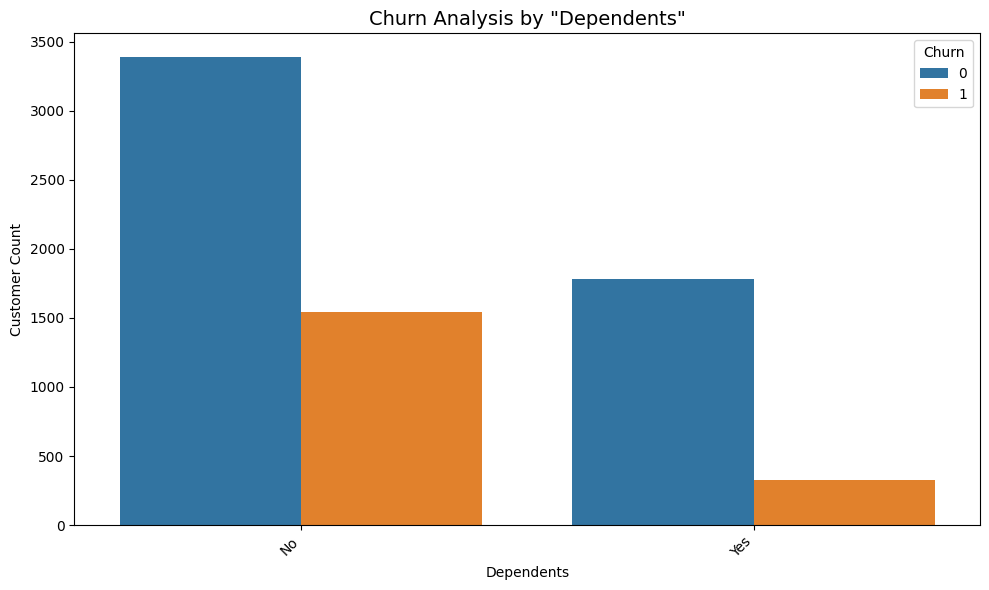

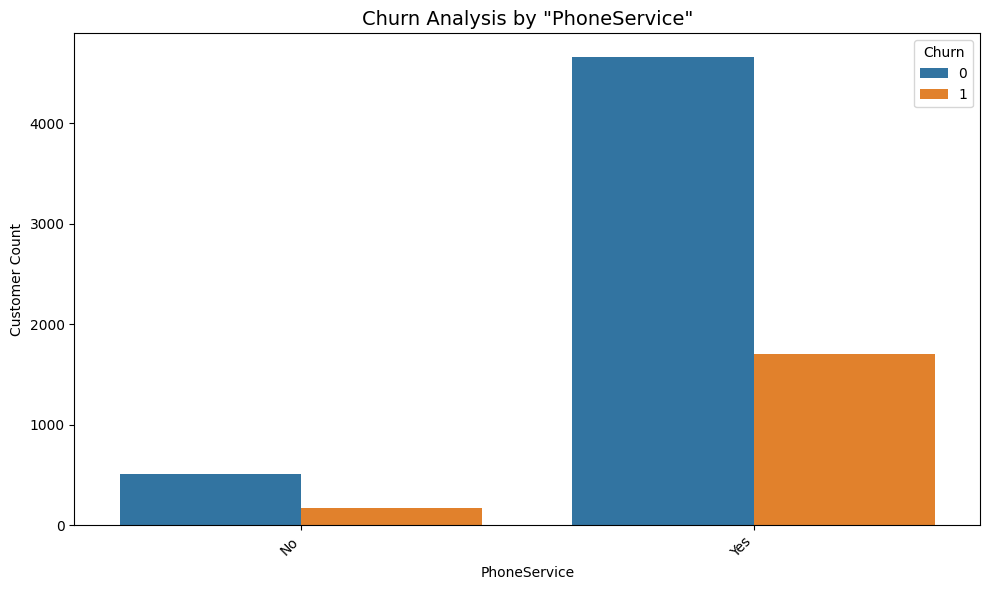

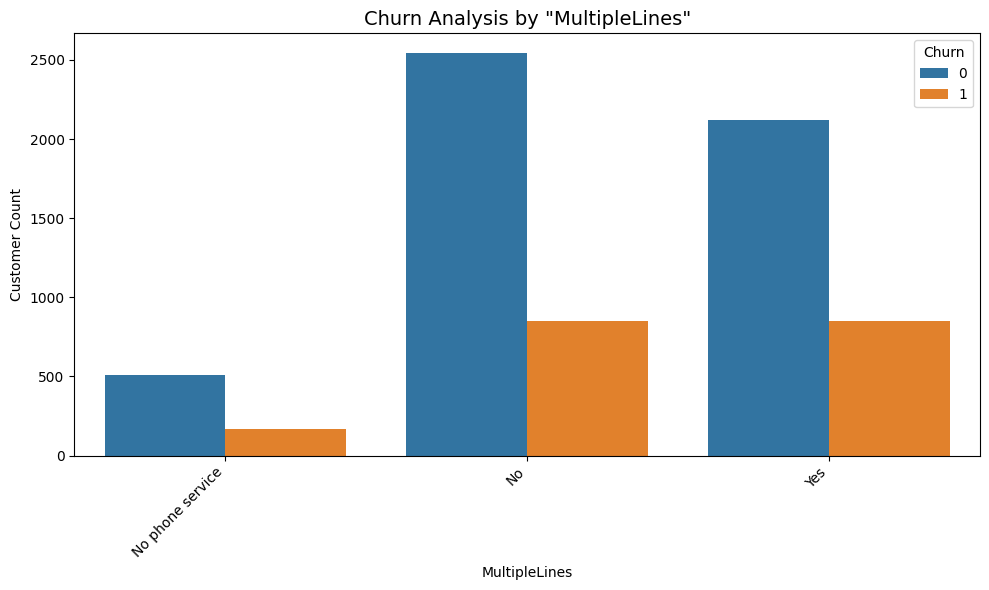

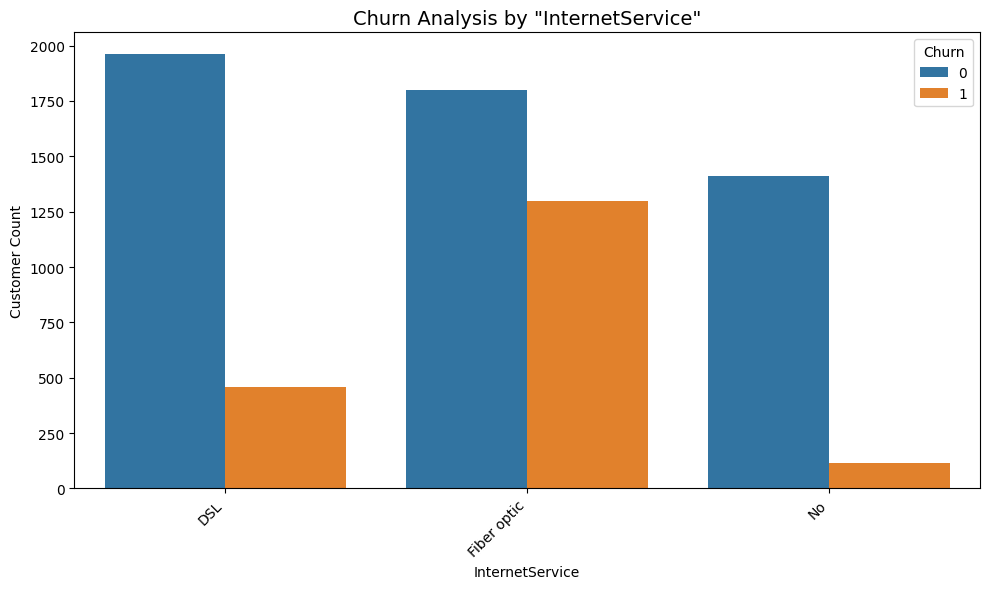

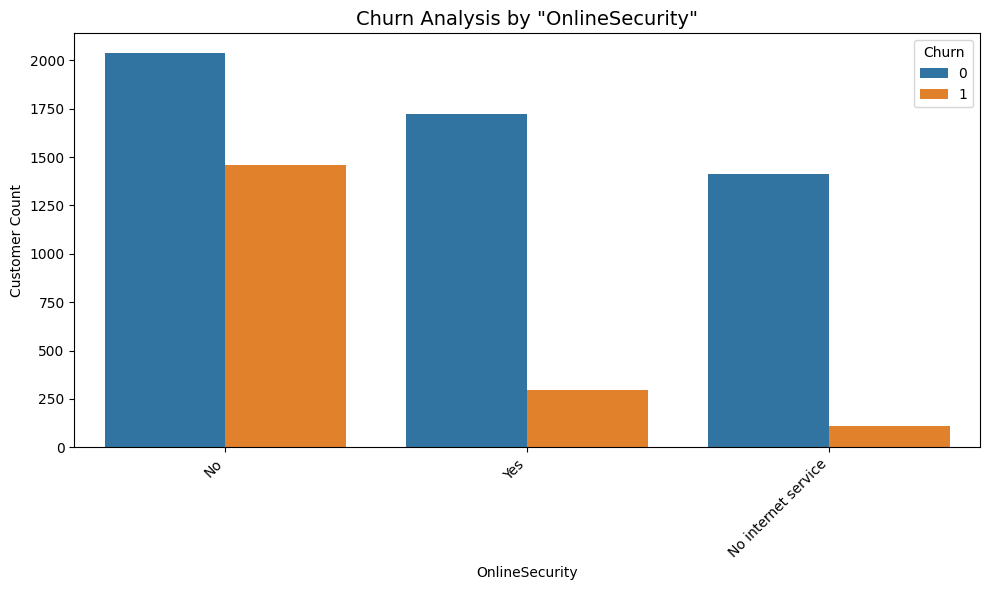

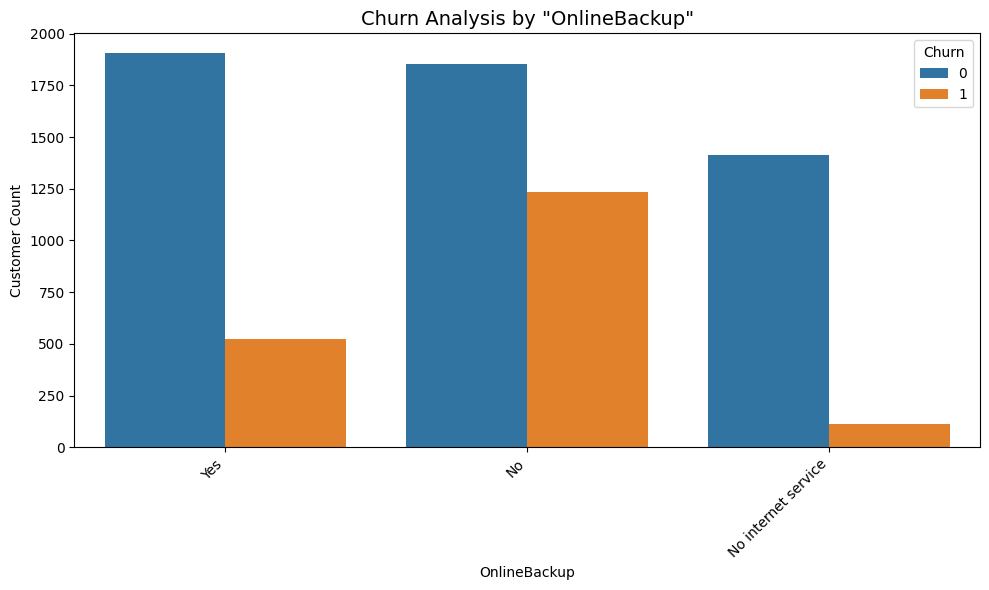

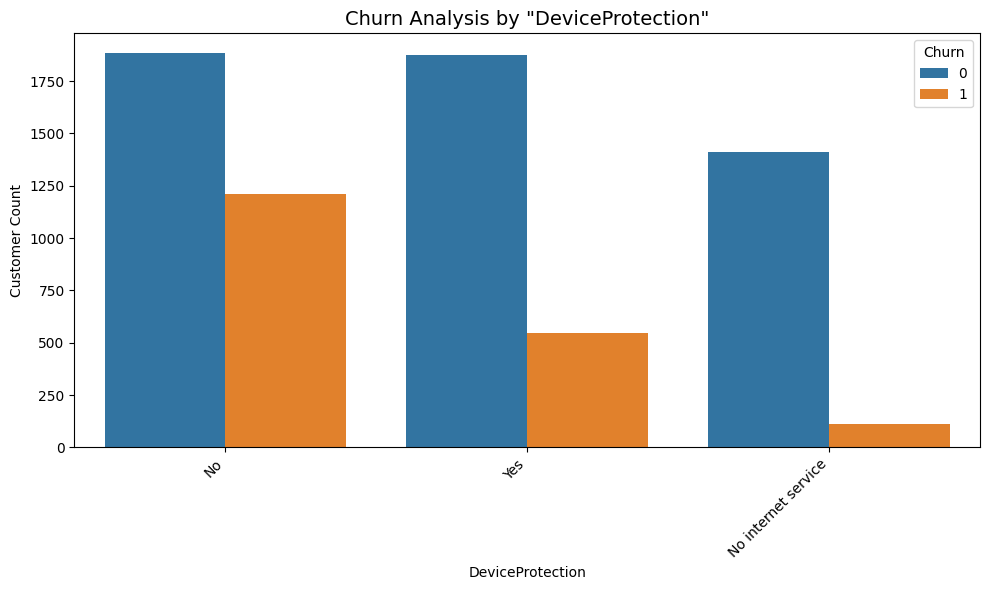

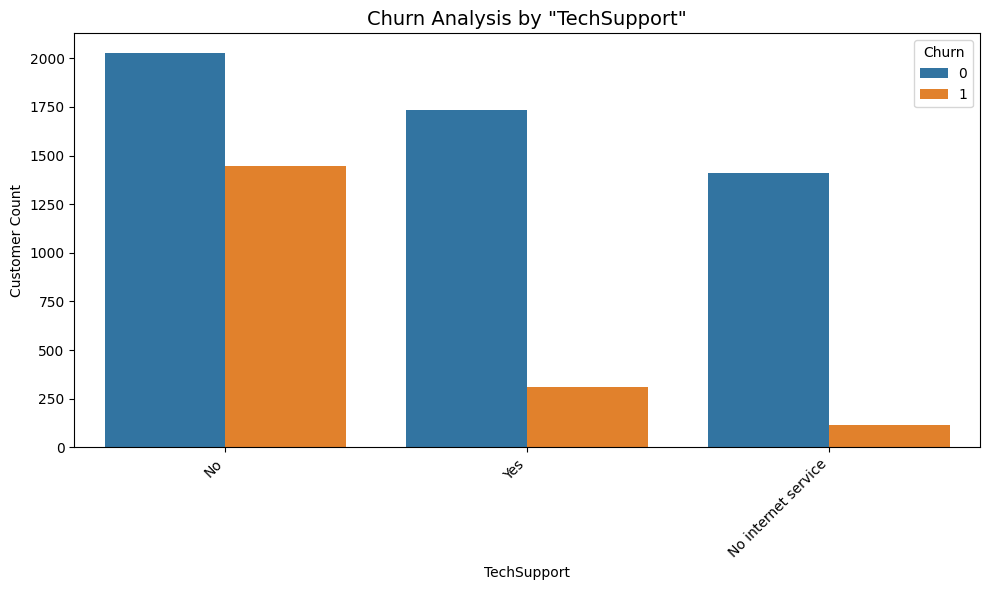

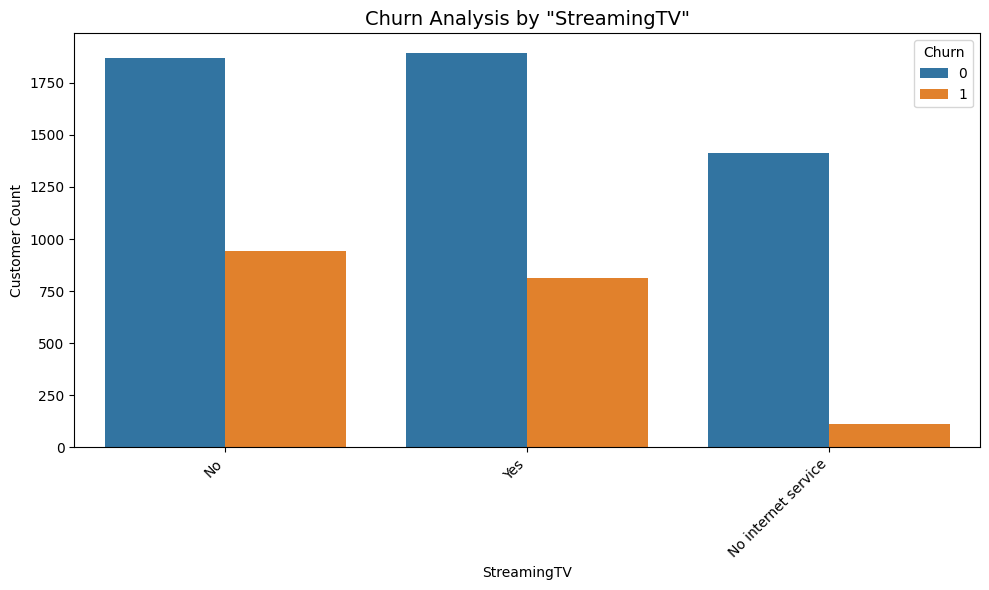

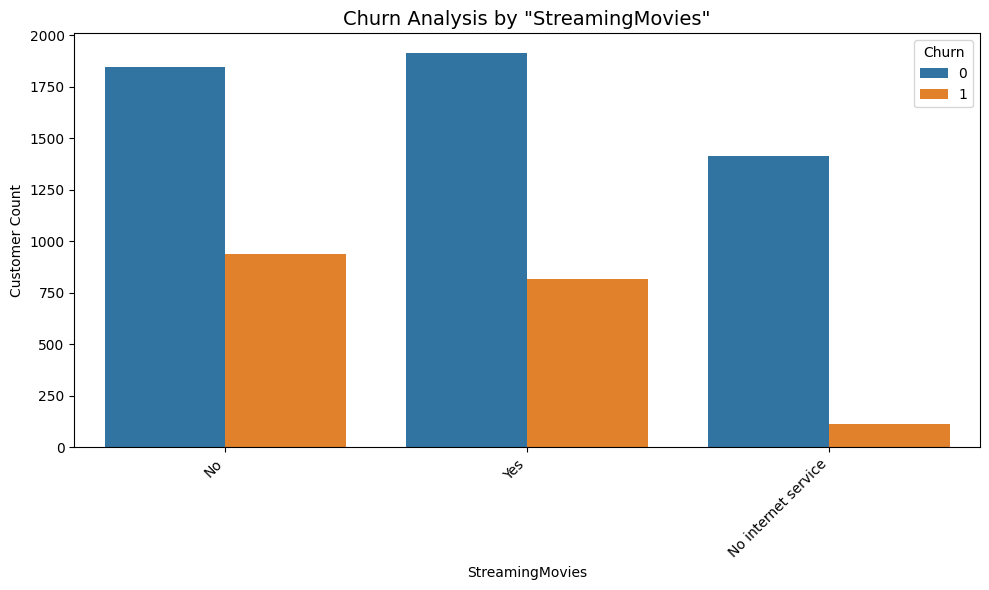

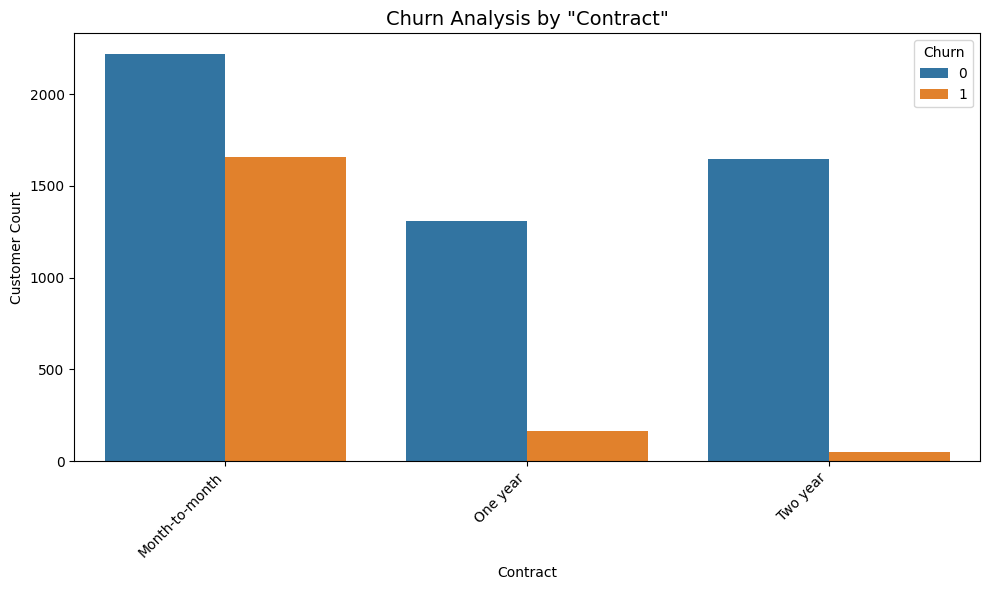

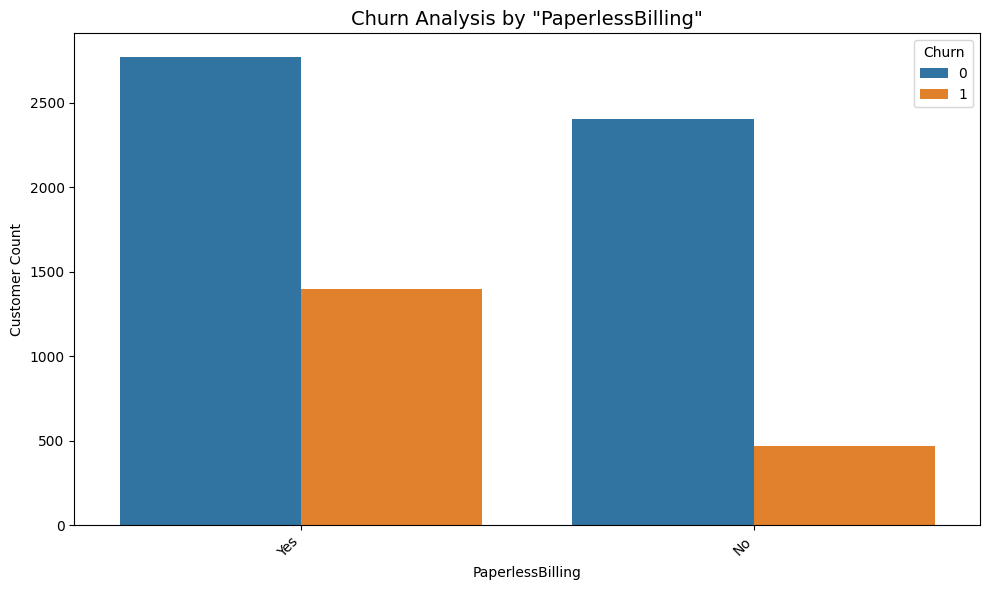

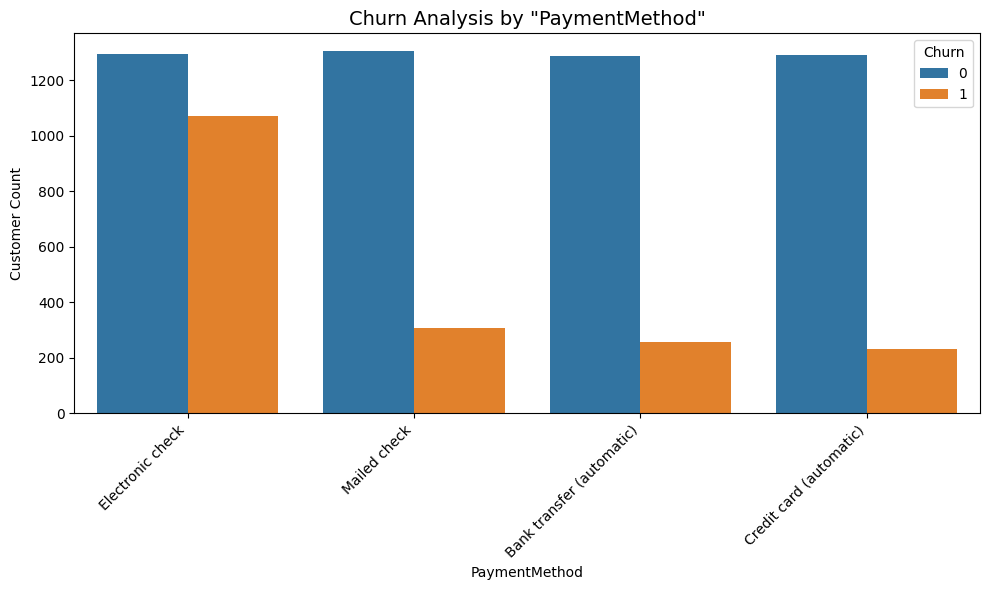

In [4]:
# --- EDA Part 2: Categorical Features vs. Churn ---
print("\nAnalyzing categorical features vs. churn...")
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn Analysis by "{col}"', fontsize=14)
    plt.ylabel("Customer Count")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Analyzing numerical features vs. churn...


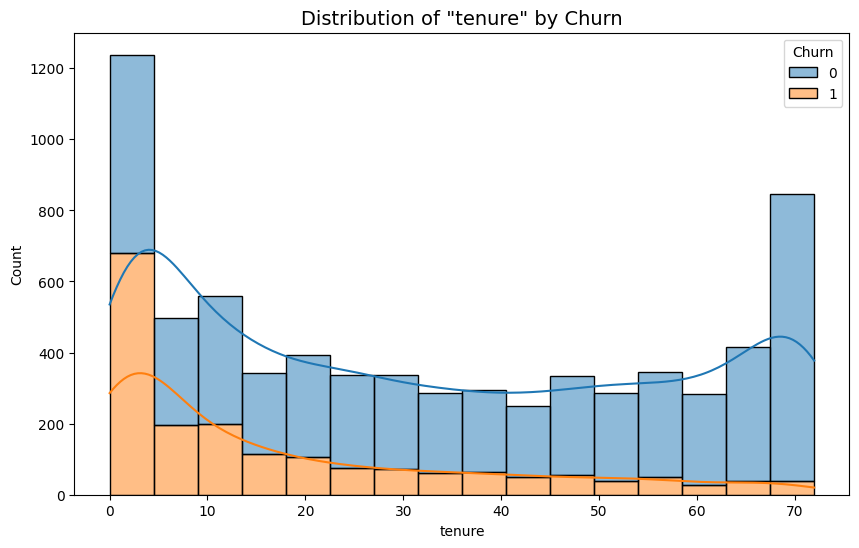

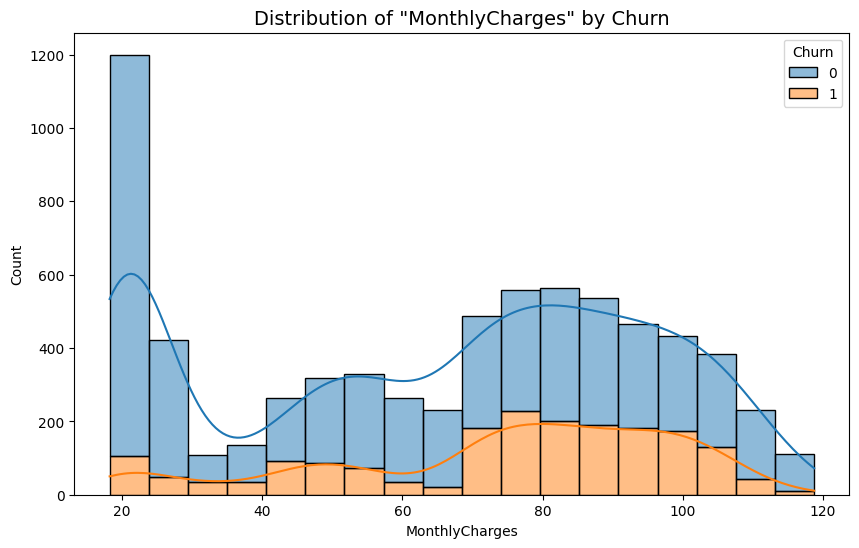

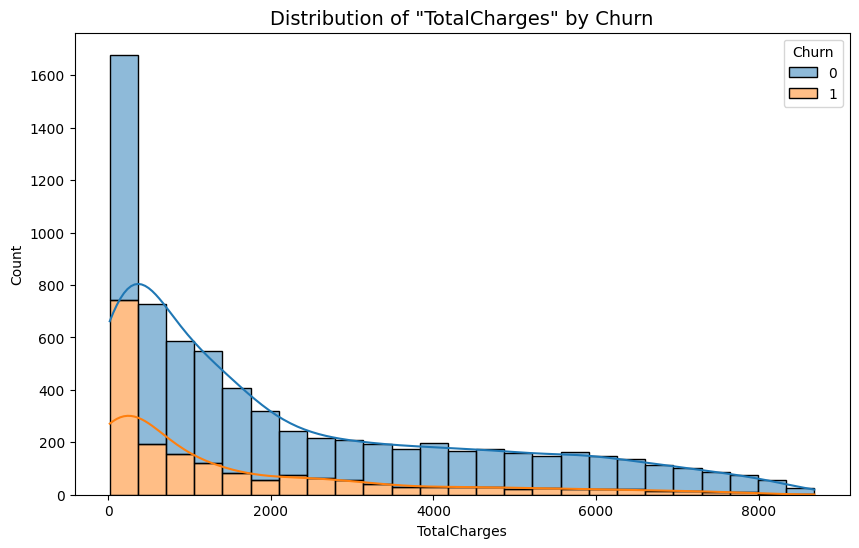

In [5]:
# --- EDA Part 3: Numerical Features vs. Churn ---
print("\nAnalyzing numerical features vs. churn...")
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, multiple='stack')
    plt.title(f'Distribution of "{col}" by Churn', fontsize=14)
    plt.show()

In [6]:
# --- Step 3: Feature Engineering and Preprocessing ---
print("\n--- Step 3: Feature Engineering and Preprocessing ---")

df_processed = df.copy()

# Feature Engineering Example: Count of support-related services
support_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df_processed['num_support_services'] = df_processed[support_services].apply(lambda row: sum(row == 'Yes'), axis=1)

# Prepare data for the pipeline
X = df_processed.drop(['customerID', 'Churn'], axis=1)
y = df_processed['Churn']

# Identify numerical and categorical columns for the preprocessor
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols.append('num_support_services') # Add our new feature

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Build the preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)
print("\nPreprocessing pipeline created successfully!")



--- Step 3: Feature Engineering and Preprocessing ---
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'num_support_services', 'num_support_services']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Preprocessing pipeline created successfully!


In [7]:
# --- Step 4: Baseline Model with XGBoost and Cross-Validation ---
print("\n--- Step 4: Baseline Model Training ---")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the full pipeline with preprocessor and classifier
# The 'use_label_encoder=False' parameter is removed as it's deprecated.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate baseline scores using cross-validation
baseline_scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv_strategy, scoring='roc_auc')

print(f"\nBaseline Model Performance (Cross-Validation)")
print(f"ROC AUC Scores for each fold: {baseline_scores}")
print(f"Mean ROC AUC: {baseline_scores.mean():.4f}")
print(f"Standard Deviation of ROC AUC: {baseline_scores.std():.4f}")


--- Step 4: Baseline Model Training ---

Baseline Model Performance (Cross-Validation)
ROC AUC Scores for each fold: [0.81673816 0.81258583 0.82264553 0.83073005 0.8269706 ]
Mean ROC AUC: 0.8219
Standard Deviation of ROC AUC: 0.0066


In [8]:
# --- Step 5: Hyperparameter Optimization with Optuna ---
print("\n--- Step 5: Hyperparameter Optimization with Optuna ---")

def objective(trial):
    params = {
        'classifier__n_estimators': trial.suggest_int('n_estimators', 400, 2000),
        'classifier__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'classifier__max_depth': trial.suggest_int('max_depth', 3, 10),
        'classifier__subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'classifier__colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'classifier__gamma': trial.suggest_float('gamma', 0, 5),
        'classifier__lambda': trial.suggest_float('lambda', 0, 10),
        'classifier__alpha': trial.suggest_float('alpha', 0, 10),
    }

    pipeline_opt = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
    ])
    pipeline_opt.set_params(**params)

    score = cross_val_score(pipeline_opt, X_train, y_train, cv=cv_strategy, scoring='roc_auc').mean()
    return score

# Create and run the optimization study
study = optuna.create_study(direction='maximize')
print("Starting optimization with Optuna... (This may take a few minutes)")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n--- Optuna Optimization Results ---")
print(f"Best ROC AUC score (cross-validation): {study.best_value:.4f}")
print("Best hyperparameters found:")
print(study.best_params)

[I 2025-06-15 20:14:01,475] A new study created in memory with name: no-name-1bc2ba59-4c42-46bb-9672-f8a14842624a



--- Step 5: Hyperparameter Optimization with Optuna ---
Starting optimization with Optuna... (This may take a few minutes)


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-15 20:14:03,297] Trial 0 finished with value: 0.8363913754812371 and parameters: {'n_estimators': 1842, 'learning_rate': 0.12162521951967949, 'max_depth': 8, 'subsample': 0.797295663462346, 'colsample_bytree': 0.9973935207184208, 'gamma': 0.40406857286334863, 'lambda': 4.124740885062213, 'alpha': 5.105195520991915}. Best is trial 0 with value: 0.8363913754812371.
[I 2025-06-15 20:14:04,073] Trial 1 finished with value: 0.8482755481331428 and parameters: {'n_estimators': 1201, 'learning_rate': 0.14793806114170416, 'max_depth': 10, 'subsample': 0.7451029366679705, 'colsample_bytree': 0.8582162743845475, 'gamma': 4.787829904808944, 'lambda': 8.256412324570451, 'alpha': 7.892738115749984}. Best is trial 1 with value: 0.8482755481331428.
[I 2025-06-15 20:14:04,959] Trial 2 finished with value: 0.8488483601345701 and parameters: {'n_estimators': 1552, 'learning_rate': 0.23462187273478652, 'max_depth': 3, 'subsample': 0.9824230126447293, 'colsample_bytree': 0.8834598177777885, 'gam


--- Step 6: Final Model Training and Evaluation ---

Training the final model...
Final model trained successfully!

--- Final Evaluation on the Test Set ---
ROC AUC Score (Test): 0.8490

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.66      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


Confusion Matrix:


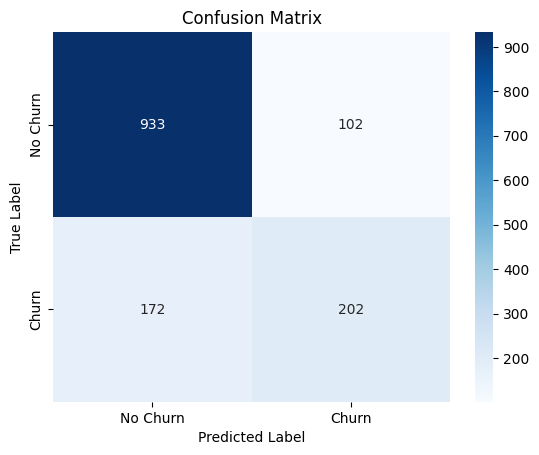


ROC Curve:


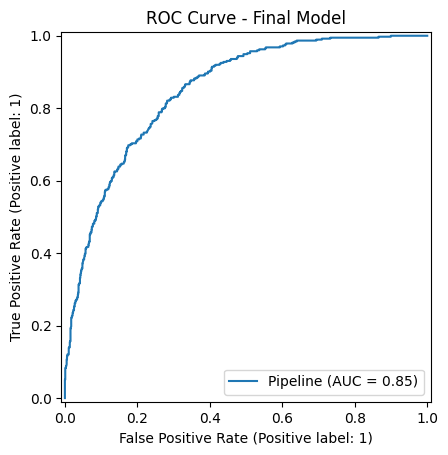


--- Feature Importance ---


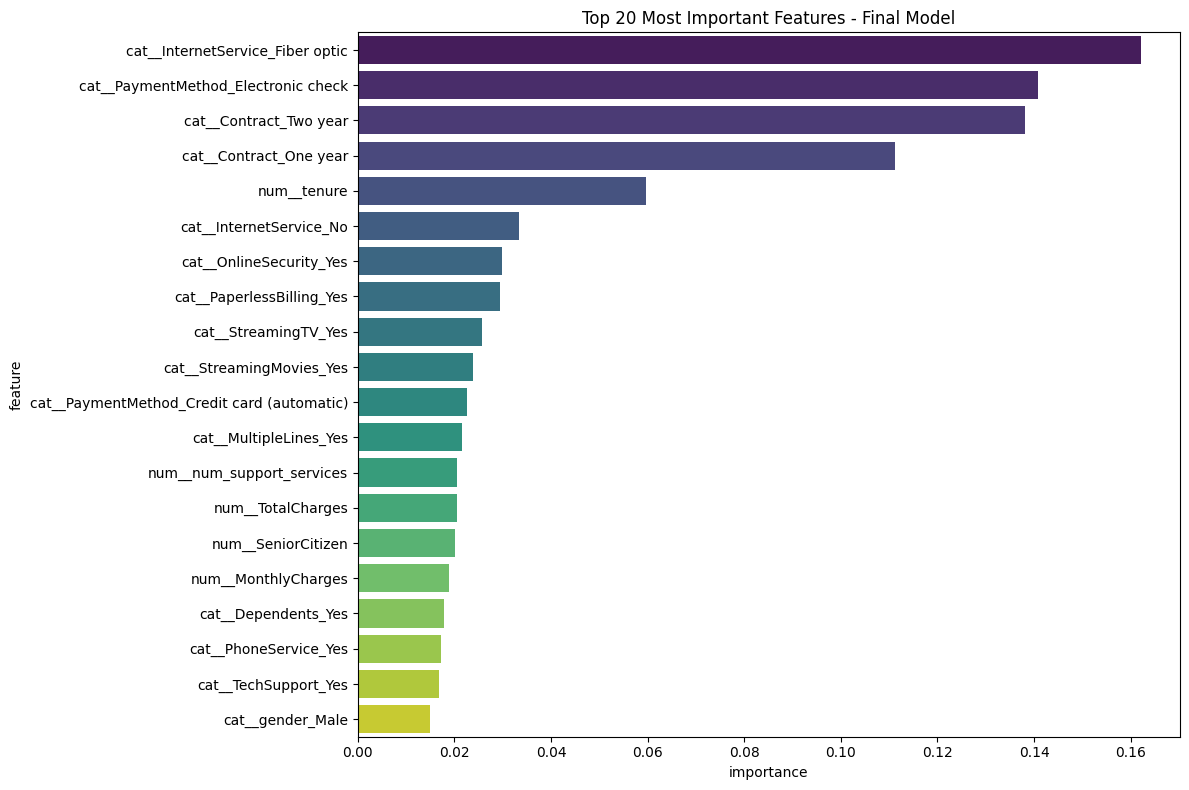


--- Project Complete ---


In [9]:
# --- Step 6: Final Model Training, Evaluation, and Interpretation ---
print("\n--- Step 6: Final Model Training and Evaluation ---")

# Get best params and format them for the pipeline
best_params_from_study = {f"classifier__{key}": value for key, value in study.best_params.items()}

# Create the final model with the best parameters
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
])
final_model.set_params(**best_params_from_study)

# Train the final model on the entire training set
print("\nTraining the final model...")
final_model.fit(X_train, y_train)
print("Final model trained successfully!")

# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# --- Final Evaluation on Test Set ---
print("\n--- Final Evaluation on the Test Set ---")
print(f"ROC AUC Score (Test): {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nROC Curve:")
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.title('ROC Curve - Final Model')
plt.show()

# --- Model Interpretation ---
print("\n--- Feature Importance ---")
xgb_classifier = final_model.named_steps['classifier']
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize the top 20 most important features
plt.figure(figsize=(12, 8))
# Corrected barplot call to avoid FutureWarning
sns.barplot(x='importance', y='feature', data=importances.head(20), hue='feature', palette='viridis', legend=False)
plt.title('Top 20 Most Important Features - Final Model')
plt.tight_layout()
plt.show()

print("\n--- Project Complete ---")
